In [1]:
import sys
sys.path.insert(1, '/home/sam/Documents/network/supernode/BREC_test/')

In [2]:
import numpy as np
import torch
import torch_geometric
import torch_geometric.loader
from loguru import logger
import time
from BRECDataset_v3 import BRECDataset
from tqdm import tqdm
import os
from torch.nn import CosineEmbeddingLoss
import argparse

from torch import nn
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from torch_geometric.utils import degree
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GIN, MLP, global_add_pool
import torch_geometric.transforms as T

import hashlib

from concepts.concepts import *
from concepts.transformations import AddSupernodes
from models.gnn_hetero_multi import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import numpy as np
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx

In [3]:
def get_dataset_normal(device):
    time_start = time.process_time()

    def makefeatures(data):
        data.x = torch.ones((data.num_nodes, 1))
        return data


    name = f"BREC_supernode_multi_normal"

    # Do something
    dataset = BRECDataset(dataset_path="/home/sam/Documents/network/supernode/dataset/BREC_raw",
                          name=name,
                          pre_transform=makefeatures)

    return dataset

In [4]:
dataset = get_dataset_normal(device)

In [5]:
dataset[0]

Data(edge_index=[2, 52], x=[10, 1], num_nodes=10)

In [6]:
concepts_list = [
       {"name": "GCB", "fun": cycle_basis, "args": [], "features" : [2]},
       {"name": "GMC", "fun": max_cliques, "args": []},
    ]

data = AddSupernodes(concepts_list)(dataset[0])
data.x

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

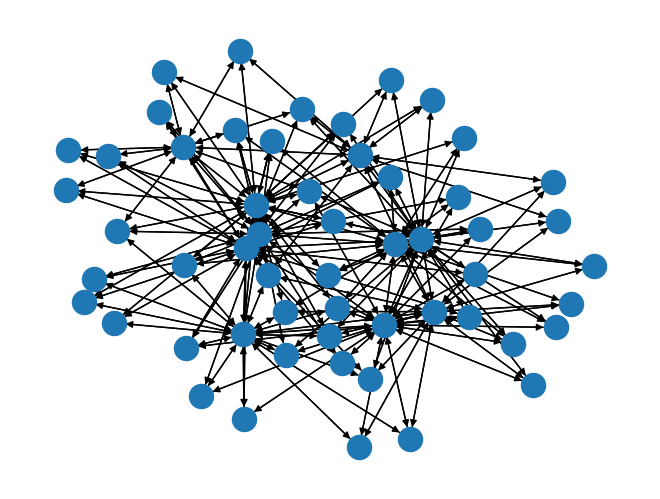

In [7]:
nx.draw(to_networkx(data))

## UPDATE SUPERNODES

In [8]:
data = AddSupernodes(concepts_list)(dataset[0])
x = data.x
supernode_mask = data.S > 0
supernode_edge_mask = data.edge_S > 0

In [9]:
from torch_geometric.nn import SimpleConv
sc = SimpleConv("sum")

x2 = sc(x, data.edge_index, supernode_edge_mask)
x[supernode_mask] = x2[supernode_mask]


## UPDATE NORMAL NODE

In [10]:
data = AddSupernodes(concepts_list)(dataset[0])
x = data.x
normalnode_mask = data.S <= 0
# normalnode_edge_mask = data.edge_S <= 0 #not used since we want to update normal nodes also with supernodes values

In [11]:
from torch_geometric.nn import SimpleConv
sc = SimpleConv("sum")

x2 = sc(x, data.edge_index)
x[normalnode_mask] = x2[normalnode_mask]

In [12]:
data.S

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1])

## GIN CONV

In [13]:
from torch_geometric.nn import SimpleConv, GINConv, MLP
hidden_channels = 32
data = AddSupernodes(concepts_list)(dataset[0])

### update supernodes as sum of neighbours

In [14]:
x = data.x
edge_index = data.edge_index

supernode_mask = data.S > 0
supernode_edge_mask = data.edge_S > 0
normalnode_mask = data.S <= 0

sc = SimpleConv("sum")
x2 = sc(x, edge_index, supernode_edge_mask)
x[supernode_mask] = x2[supernode_mask]
x

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [5.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [4.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [4.],
        [3.],
        [3.],
        [4.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.]])

### apply gin to normal nodes

In [15]:
ginconv = GINConv(MLP([-1, hidden_channels, hidden_channels]))

# apply ginconv to all nodes
x = ginconv(x, edge_index)

# apply supernode calculation
sc = SimpleConv("sum")
x2 = sc(x, edge_index, supernode_edge_mask)
x[supernode_mask] = x2[supernode_mask]

x

tensor([[ 0.4615,  0.4716,  0.4836,  ..., -0.8060,  0.0478, -0.0556],
        [ 0.8200,  1.0263,  0.8696,  ..., -1.6210,  0.0389,  0.0508],
        [ 0.6953,  0.8334,  0.7353,  ..., -1.3375,  0.0420,  0.0137],
        ...,
        [ 2.8497,  3.6819,  3.0282,  ..., -5.7490,  0.1071,  0.2679],
        [ 2.4756,  3.1030,  2.6255,  ..., -4.8985,  0.1163,  0.1569],
        [ 3.0212,  3.9472,  3.2128,  ..., -6.1388,  0.1028,  0.3188]],
       grad_fn=<IndexPutBackward0>)

## GIN_SGIN

In [16]:
from torch_geometric.nn import SimpleConv, GINConv, MLP
hidden_channels = 32
data = AddSupernodes(concepts_list)(dataset[0])

In [17]:
## initialize supernodes with sum
x = data.x
edge_index = data.edge_index

supernode_mask = data.S > 0
supernode_edge_mask = data.edge_S > 0
normalnode_mask = data.S <= 0

sc = SimpleConv("sum")
x2 = sc(x, edge_index, supernode_edge_mask)
x[supernode_mask] = x2[supernode_mask]

In [18]:
## apply gin to all the nodes
ginall = GINConv(MLP([-1, hidden_channels, hidden_channels]))
ginSup = GINConv(MLP([-1, hidden_channels, hidden_channels]))

# apply ginconv to all nodes
x = ginall(x, edge_index)

# compute the supernode values as GIN of neighbours
x2 = ginSup(x, edge_index)
x[supernode_mask] = x2[supernode_mask]

## CONCEPT FEATURE

In [19]:
concepts_list = [
       {"name": "GCB", "fun": cycle_basis, "args": [], "feature" : [0,0,1]},
       {"name": "GMC", "fun": max_cliques, "args": [], },
    ]


In [20]:
torch.ones((3, 1))

tensor([[1.],
        [1.],
        [1.]])

In [21]:
torch.tensor([1,0,0] * 3)

tensor([1, 0, 0, 1, 0, 0, 1, 0, 0])

In [22]:
custom_value = [1.0, 1.0, 4.0]
custom_tensor = torch.tensor(custom_value).repeat(3,1)
custom_tensor

tensor([[1., 1., 4.],
        [1., 1., 4.],
        [1., 1., 4.]])

In [25]:
data = AddSupernodes(concepts_list)(dataset[0])
data

Data(x=[55, 1], edge_index=[2, 354], ntype=[55], S=[55], edge_S=[354, 1])

In [26]:
data.y